## Experimento 2.
## Predicción de permanencia de migrantes mexicanos en situación irregular en Estados Unidos tras la promulgación de la $\textit{IIRIRA}$

Selección y limpieza de datos a partir de las tablas <b>MIG</b> y <b>MIGOTHER</b>.

La tabla <b>MIG</b> contiene información a nivel personal y detalles sobre todos los cruces indocumentados (hasta 30) de cada jefe de familia, así como toda la actividad económica y social durante el último viaje migratorio a los Estados Unidos.

La tabla <b>MIGOTHER</b> contiene la misma información pero considera otra persona del hogar que emigró a los Estados Unidos en aquellos hogares donde el jefe del hogar no tuvo experiencia migratoria.

El dataset se forma a partir de la combinación de ambas tablas considerando aquellas columnas que comparten. (Ver documentación para detalles)

Para este experimento se considera solamente información pertinente al último viaje migratorio realizado, tomando como etiqueta de clase al campo 'uscurtrp' que responde a la pregunta ¿Actualmente se está en último viaje migratorio?.

Así, la etiqueta de clase puede tomar dos valores posibles:<br>
>1: Sí (No ha regresado)<br>2: No (Ya regresó)<br>

Para todos los clasificadores utilizados, se tomará la clase 1 (No ha regresado) como clase **Positive**.

Esta versión del experimento realiza el entrenamiento con años anteriores al 2019. Los patrones de dicho año se utilizan para llevar a cabo la prueba.
<br>

---

In [15]:
#Definición de clases Positive y Negative
#Formato: (clase, label)
    #clase: valor numérico
    #label: valor de texto (etiqueta)
#¿Actualmente se está en último viaje migratorio?
pos_class = (1, 'Sí') #Clase positive (Sí)
neg_class = (0, 'No') #Clase negative  (No)

# Tareas previas
Añadir librerías, cargar dataset, generar dfs. calcular IR e imputar datos.

### Añadir librerías necesarias

In [3]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from tabulate import tabulate
from scipy.spatial.distance import mahalanobis

sys.path.append(os.path.abspath(os.path.join('..'))) #Utils path
from tesis_experiments_utils import classifiers_utils as cu
from tesis_experiments_utils import confusion_matrices_utils as cmu
from tesis_experiments_utils import data_utils as du
from tesis_experiments_utils import files_utils as fu
from tesis_experiments_utils import learning_curves_utils as lcu

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Cargar el dataset en un dataframe y generar los df con los datos y etiquetas

Variables para la lectura del dataset

Crear carpetas para almacenamiento de los resultados, particiones de datos, etc.

In [17]:
fu.setup_folders()

La carpeta 'particiones/hold_out' ha sido creada
La carpeta 'datos_imputados' ha sido creada
La carpeta 'matrices_de_confusion' ha sido creada
La carpeta 'curvas_de_aprendizaje' ha sido creada
La carpeta 'resultados' ha sido creada


In [18]:
#Ubicación del dataset
path_to_data = os.path.join('..', 'datasets')
path_to_file = os.path.join(path_to_data,'regreso_ultimo_viaje', 'regreso_ultimo_viaje.csv')

#Atributos categóricos del dataset
cat_atts = ['sex', 'statebrn', 'placebrn', 'marstat', 'edyrs', 'occ', 'usyrl', 'usdocl', 'usstatel', 'usplacel', 'usoccl', 'usbyl', 'reltrip', 'paistrip', 'sport', 'social', 'chicanos',
            'blacks', 'anglos', 'latinos', 'lodging', 'english', 'finhelp', 'bankacct', 'remit1', 'remit2', 'remit3', 'remit4', 'remit5', 'savings1', 'savings2', 'savings3', 'savings4',
            'savings5', 'schools', 'unemp', 'foodst', 'welfare', 'doctor', 'hospital']


## Métodos de validación
Definición de variables y métodos necesarios para los métodos de validación Hold-out y k-fold-cross-validation

Realizar partición fija de datos

In [19]:
#X_train, X_test, y_train, y_test = du.stratified_hold_out(path_to_file, cat_atts, test_size=0.2)
#X = pd.concat([X_train, X_test])

df = du.load_dataset(path_to_file, cat_atts)

df['usyrl'] = df['usyrl'].astype('int64')

#Datos distintos anteriores a 1997 para entrenamiento
df_train = df[(df['usyrl'] <= 1996)]

#Datos posteriores a 1997  para prueba, durante el periodo de la IIRIRA
df_test = df[(df['usyrl'] > 1996)]

X_train = df_train.drop(df_train.columns[-1], axis=1)
y_train = df_train[df_train.columns[-1]]

X_test = df_test.drop(df_test.columns[-1], axis=1)
y_test = df_test[df_test.columns[-1]]

#Almacenamiento de las particiones de datos
data_dir = os.path.join("particiones", "particion_fija")
try:
    os.makedirs(data_dir)
    print(f"La carpeta '{data_dir}' ha sido creada")
except FileExistsError:
    print(f"La carpeta '{data_dir}' ya existe")
finally:
    X_train.to_csv(os.path.join(data_dir, "X_train.csv"), index=False)
    X_test.to_csv(os.path.join(data_dir, "X_test.csv"), index=False)
    y_train.to_csv(os.path.join(data_dir, "y_train.csv"), index=False)
    y_test.to_csv(os.path.join(data_dir, "y_test.csv"), index=False)

La carpeta 'particiones/particion_fija' ha sido creada


Codificación de etiquetas de clase:

    1: Sí (no ha regresado), originalmente 1
    0: No (regresó), originalmente 2

In [20]:
y_train = np.array([0 if i == 2 else 1 for i in y_train])
y_test = np.array([0 if i == 2 else 1 for i in y_test])

### K-fold Cross Validation

In [21]:
kf_cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=94)

### Cálculo de Imbalance Ratio

In [22]:
#y = np.concatenate((y_train, y_test))
y = y_train

card_class1 = sum(1 for l in y if l == pos_class[0]) #Cardinalidad de la clase 1
card_class2 = sum(1 for l in y if l == neg_class[0]) #Cardinalidad de la clase 2

IR = max(card_class1,card_class2)/min(card_class1,card_class2)

print("Instancias en el dataset: %i" % len(y))
print("Cadinalidad de la clase 1: %i" % card_class1)
print("Cadinalidad de la clase 2: %i" % card_class2)


if(IR <= 1.5):
  print("Dataset balanceado con IR = %.4f" % IR)
else:
  print("Dataset desbalanceado con IR = %.4f" % IR)


Instancias en el dataset: 6852
Cadinalidad de la clase 1: 1508
Cadinalidad de la clase 2: 5344
Dataset desbalanceado con IR = 3.5438


## Imputación de datos perdidos

In [23]:
X_train, X_test = du.impute_data(X_train, X_test, cat_atts,'median')

Archivo 'X_train_imputed_median.csv' no encontrado en 'datos_imputados'
Imputando valores faltantes en los conjuntos de datos utilizando la estrategia 'median'



Se han imputado y almacenado los conjuntos de datos en 'datos_imputados'


## Normalización del dataset para utilizarlo con clasificadores basádos en métricas

Normalización de los atributos del dataset utilizando la forma:

$
    \Large z = \frac{(x-\mu)}{\sigma}
$

También conocida como z-score

In [24]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out()) # type: ignore
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out()) # type: ignore

## One hot encoding sobre atributos categóricos para utilizarlo con clasificadores basados en reglas

In [25]:
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#pd.concat(atributos no categóricos, atributos categóricos codificados, nombre de columnas, axis)
X_train_encoded = pd.concat([X_train.drop(cat_atts, axis=1), 
                             pd.DataFrame(encoder.fit_transform(X_train[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)
X_test_encoded = pd.concat([X_test.drop(cat_atts, axis=1),
                            pd.DataFrame(encoder.transform(X_test[cat_atts]).toarray(), columns=encoder.get_feature_names_out(cat_atts))],axis=1)

/home/daniel/anaconda3/envs/migration/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 5, 6, 7, 8, 9, 10, 11, 28] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Clasificadores k-NN

Experimentación con la distancia de Mahalanobis

In [26]:
cov_matrix = np.cov(X_train_scaled.T)

def mahalanobis_distance(X, y):
    return mahalanobis(X, y, np.linalg.inv(cov_matrix))

In [27]:
scoring = ['matthews_corrcoef', 'balanced_accuracy'] #Métricas de evaluación para selección de modelos
score_validation = 'matthews_corrcoef' #Métrica de evaluación para learning curve

### **Elección del parámetro k**

Elección del parámetro k que minimiza el error de generalización utilizando *10-fold cross validation* a partir del Coeficiente de Correlación de Matthews.

In [28]:
k_range = range(1,52,2)
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
params = {'n_neighbors': k_range, 'metric': metrics}
knn = KNeighborsClassifier()

best_knn = GridSearchCV(knn,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_knn.fit(X_train_scaled, y_train)
end = time.time()
best_mcc = best_knn.best_score_
best_k = best_knn.best_params_['n_neighbors']
best_metric = best_knn.best_params_['metric']

fu.write_cross_val_times_to_file(
        {"Classifier": f'{best_k}-NN', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Mejor k: {best_k}, mejor métrica: {best_metric}, MCC media: {best_mcc:.4f}.')

Fitting 10 folds for each of 104 candidates, totalling 1040 fits


[CV 1/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.766) matthews_corrcoef: (test=0.537) total time=   0.1s
[CV 7/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.796) matthews_corrcoef: (test=0.573) total time=   0.1s
[CV 8/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.790) matthews_corrcoef: (test=0.590) total time=   0.1s
[CV 5/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.789) matthews_corrcoef: (test=0.574) total time=   0.1s
[CV 4/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.797) matthews_corrcoef: (test=0.585) total time=   0.1s
[CV 6/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.775) matthews_corrcoef: (test=0.550) total time=   0.1s
[CV 3/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.788) matthews_corrcoef: (test=0.565) total time=   0.1s
[CV 2/10] END metric=euclidean, n_neighbors=1; balanced_accuracy: (test=0.770) matthews_co

Archivo de curvas de aprendizaje creado en curvas_de_aprendizaje/curvas_de_aprendizaje.csv
Curvas de aprendizaje del clasificador 7-NN almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Archivo de tiempos de curvas de aprendizaje creado en curvas_de_aprendizaje/learning_curves_times.csv
Tiempo de curvas de aprendizaje del clasificador 7-NN almacenado en curvas_de_aprendizaje/learning_curves_times.csv


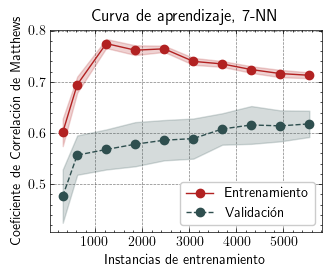

In [29]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
lcu.plot_and_save_learning_curve(knn, f'{best_k}-NN',X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Archivo de resultados creado en resultados/resultados.csv
Resultados del clasificador 7-NN almacenados en resultados/resultados.csv
Archivo de predicciones creado en resultados/predicciones.csv
Predicciones del clasificador 7-NN almacenadas en resultados/predicciones.csv.
Archivo de tiempos de ejecución creado en resultados/execution_times.csv
Tiempo de ejecución del clasificador 7-NN almacenado en resultados/execution_times.csv
Accuracy: 0.6980
Balanced accuracy: 0.6098
Recall: 0.2526
Specificity: 0.9669
AUC: 0.2526
MCC: 0.3326
Precision: 0.8219
F1-score: 0.3865


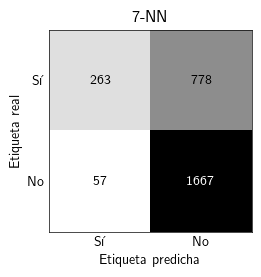

In [30]:
cu.train_and_evaluate_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, f'{best_k}-NN',pos_class,neg_class)

# Naïve Bayes

### **Naïve Bayes**

Curvas de aprendizaje del clasificador Naïve Bayes almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Naïve Bayes almacenado en curvas_de_aprendizaje/learning_curves_times.csv


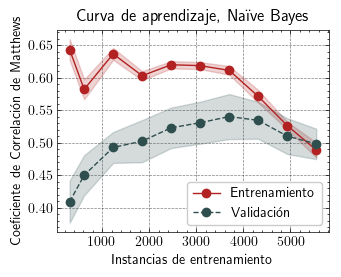

In [ ]:
fu.write_cross_val_times_to_file(
        {"Classifier": 'Naïve Bayes', "time_s": 0}
)
nb = GaussianNB()
lcu.plot_and_save_learning_curve(nb, 'Naïve Bayes',X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Naïve Bayes almacenados en resultados/resultados.csv
Predicciones del clasificador Naïve Bayes almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Naïve Bayes almacenado en resultados/execution_times.csv
Accuracy: 0.7045
Balanced accuracy: 0.7231
Recall: 0.7983
Specificity: 0.6479
AUC: 0.7983
MCC: 0.4327
Precision: 0.5779
F1-score: 0.6704


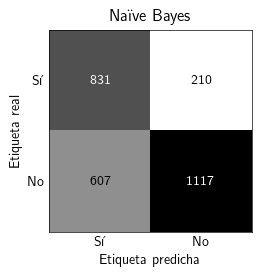

In [32]:
cu.train_and_evaluate_model(nb, X_train_encoded, y_train, X_test_encoded, y_test, 'Naïve Bayes',pos_class,neg_class)

# Decision Tree

In [33]:
depth_range = range(1,52)
params = {'max_depth': depth_range}
dtree = DecisionTreeClassifier()
best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_tree.fit(X_train_encoded, y_train)
end = time.time()
t1 = end - start
best_mcc = best_tree.best_score_
best_depth = best_tree.best_params_['max_depth']

print(f'Best MCC: {best_mcc}, best depth: {best_depth}')

Fitting 10 folds for each of 51 candidates, totalling 510 fits
[CV 2/10] END max_depth=1; balanced_accuracy: (test=0.795) matthews_corrcoef: (test=0.594) total time=   0.2s
[CV 3/10] END max_depth=1; balanced_accuracy: (test=0.772) matthews_corrcoef: (test=0.531) total time=   0.2s
[CV 1/10] END max_depth=1; balanced_accuracy: (test=0.774) matthews_corrcoef: (test=0.540) total time=   0.2s
[CV 5/10] END max_depth=1; balanced_accuracy: (test=0.737) matthews_corrcoef: (test=0.464) total time=   0.2s
[CV 9/10] END max_depth=1; balanced_accuracy: (test=0.759) matthews_corrcoef: (test=0.508) total time=   0.1s
[CV 6/10] END max_depth=1; balanced_accuracy: (test=0.784) matthews_corrcoef: (test=0.575) total time=   0.2s
[CV 7/10] END max_depth=1; balanced_accuracy: (test=0.811) matthews_corrcoef: (test=0.600) total time=   0.2s
[CV 8/10] END max_depth=1; balanced_accuracy: (test=0.772) matthews_corrcoef: (test=0.540) total time=   0.2s
[CV 10/10] END max_depth=1; balanced_accuracy: (test=0.78

In [34]:
min_samples_split_range = range(2,41)
min_samples_leaf_range = range(1,21)
params = {'min_samples_split': min_samples_split_range, 'min_samples_leaf':min_samples_leaf_range}
dtree = DecisionTreeClassifier(max_depth=best_depth)
best_tree = GridSearchCV(dtree,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, return_train_score=False, verbose=3)
start = time.time()
best_tree.fit(X_train_encoded, y_train)
end = time.time()
t2 = end - start
best_mcc = best_tree.best_score_
best_min_samples_split = best_tree.best_params_['min_samples_split']
best_min_samples_leaf = best_tree.best_params_['min_samples_leaf']
fu.write_cross_val_times_to_file(
        {"Classifier": 'Decision Tree', "time_s": t1 + t2}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(t1 + t2)))
print(f'Best MCC: {best_mcc}, Min_samples_split: {best_min_samples_split} Min_samples_leaf: {best_min_samples_leaf}')

Fitting 10 folds for each of 780 candidates, totalling 7800 fits
[CV 2/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.838) matthews_corrcoef: (test=0.699) total time=   0.3s
[CV 4/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.828) matthews_corrcoef: (test=0.693) total time=   0.3s
[CV 7/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.870) matthews_corrcoef: (test=0.761) total time=   0.3s
[CV 8/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.853) matthews_corrcoef: (test=0.752) total time=   0.3s
[CV 5/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.828) matthews_corrcoef: (test=0.702) total time=   0.3s
[CV 6/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.845) matthews_corrcoef: (test=0.738) total time=   0.3s
[CV 10/10] END min_samples_leaf=1, min_samples_split=2; balanced_accuracy: (test=0.839) matthews_corrcoef: 

In [35]:
print(f'Best depth: {best_depth}, Best min_samples_split: {best_min_samples_split}, Best min_samples_leaf: {best_min_samples_leaf}, Best {score_validation}: {best_mcc}')

Best depth: 8, Best min_samples_split: 4, Best min_samples_leaf: 1, Best matthews_corrcoef: 0.7340683018596431


Curvas de aprendizaje del clasificador Decision Tree almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Decision Tree almacenado en curvas_de_aprendizaje/learning_curves_times.csv


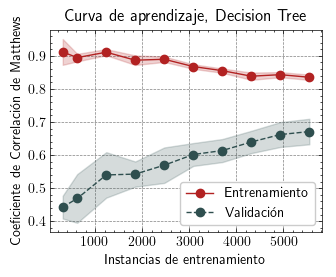

In [36]:
dtree = DecisionTreeClassifier(splitter="best", max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
lcu.plot_and_save_learning_curve(dtree, 'Decision Tree', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Decision Tree almacenados en resultados/resultados.csv
Predicciones del clasificador Decision Tree almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Decision Tree almacenado en resultados/execution_times.csv
Accuracy: 0.7483
Balanced accuracy: 0.6804
Recall: 0.4054
Specificity: 0.9553
AUC: 0.4054
MCC: 0.4544
Precision: 0.8457
F1-score: 0.5481


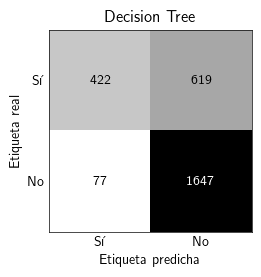

In [37]:
cu.train_and_evaluate_model(dtree, X_train_encoded, y_train, X_test_encoded, y_test, 'Decision Tree',pos_class,neg_class)

# Random Forest

In [38]:
rf = RandomForestClassifier(bootstrap=True, max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
n_estimators_range = range(100,1100,100)
params = {'n_estimators': n_estimators_range}
best_rf = GridSearchCV(rf,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_rf.fit(X_train_encoded, y_train) 
end = time.time()
best_mcc = best_tree.best_score_
best_n_estimators = best_rf.best_params_['n_estimators']

fu.write_cross_val_times_to_file(
        {"Classifier": 'Random Forest', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best MCC: {best_mcc}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END n_estimators=100; balanced_accuracy: (test=0.689) matthews_corrcoef: (test=0.551) total time=   0.8s
[CV 7/10] END n_estimators=100; balanced_accuracy: (test=0.751) matthews_corrcoef: (test=0.658) total time=   0.8s
[CV 3/10] END n_estimators=100; balanced_accuracy: (test=0.733) matthews_corrcoef: (test=0.617) total time=   0.8s
[CV 8/10] END n_estimators=100; balanced_accuracy: (test=0.746) matthews_corrcoef: (test=0.647) total time=   0.9s
[CV 6/10] END n_estimators=100; balanced_accuracy: (test=0.698) matthews_corrcoef: (test=0.576) total time=   0.9s
[CV 10/10] END n_estimators=100; balanced_accuracy: (test=0.728) matthews_corrcoef: (test=0.591) total time=   0.9s
[CV 9/10] END n_estimators=100; balanced_accuracy: (test=0.722) matthews_corrcoef: (test=0.586) total time=   1.0s
[CV 4/10] END n_estimators=100; balanced_accuracy: (test=0.677) matthews_corrcoef: (test=0.531) total time=   1.0s
[CV 5/10] END n_

Curvas de aprendizaje del clasificador Random Forest almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Random Forest almacenado en curvas_de_aprendizaje/learning_curves_times.csv


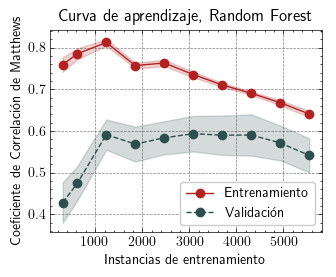

In [39]:
rf = RandomForestClassifier(n_estimators=best_n_estimators,max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=-1)
lcu.plot_and_save_learning_curve(rf, 'Random Forest', X_train_encoded, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Random Forest almacenados en resultados/resultados.csv
Predicciones del clasificador Random Forest almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Random Forest almacenado en resultados/execution_times.csv
Accuracy: 0.6474
Balanced accuracy: 0.5321
Recall: 0.0653
Specificity: 0.9988
AUC: 0.0653
MCC: 0.1979
Precision: 0.9714
F1-score: 0.1224


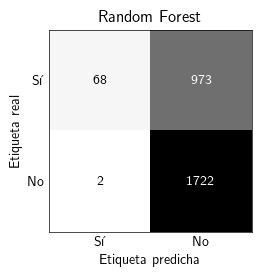

In [40]:
cu.train_and_evaluate_model(rf, X_train_encoded, y_train, X_test_encoded, y_test, 'Random Forest',pos_class,neg_class)

# Gradient Boosting Machine (GBM)

In [41]:
gbm =  GradientBoostingClassifier(criterion='friedman_mse')
n_estimators_range = range(1000,1500,100)
params = {'n_estimators': n_estimators_range}
best_gbm = GridSearchCV(gbm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_gbm.fit(X_train_scaled, y_train) 
end = time.time()
best_mcc = best_gbm.best_score_
best_n_estimators = best_gbm.best_params_['n_estimators']

fu.write_cross_val_times_to_file(
        {"Classifier": 'GBM', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best MCC: {best_mcc}, best n. estimators: {best_n_estimators}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 2/10] END n_estimators=1000; balanced_accuracy: (test=0.920) matthews_corrcoef: (test=0.862) total time=  12.6s
[CV 7/10] END n_estimators=1000; balanced_accuracy: (test=0.930) matthews_corrcoef: (test=0.875) total time=  12.6s
[CV 8/10] END n_estimators=1000; balanced_accuracy: (test=0.917) matthews_corrcoef: (test=0.849) total time=  12.6s
[CV 9/10] END n_estimators=1000; balanced_accuracy: (test=0.935) matthews_corrcoef: (test=0.869) total time=  12.6s[CV 1/10] END n_estimators=1000; balanced_accuracy: (test=0.906) matthews_corrcoef: (test=0.839) total time=  12.6s

[CV 4/10] END n_estimators=1000; balanced_accuracy: (test=0.888) matthews_corrcoef: (test=0.803) total time=  12.6s
[CV 5/10] END n_estimators=1000; balanced_accuracy: (test=0.908) matthews_corrcoef: (test=0.848) total time=  12.6s
[CV 6/10] END n_estimators=1000; balanced_accuracy: (test=0.912) matthews_corrcoef: (test=0.837) total time=  12.6s
[CV 10/10] 

Curvas de aprendizaje del clasificador GBM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador GBM almacenado en curvas_de_aprendizaje/learning_curves_times.csv


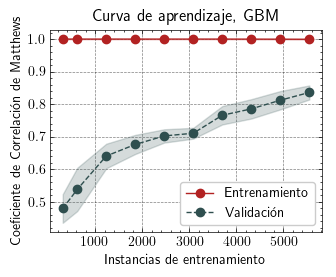

In [42]:
gbm = GradientBoostingClassifier(n_estimators=best_n_estimators, criterion='friedman_mse')
lcu.plot_and_save_learning_curve(gbm, 'GBM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:12
Tiempo de evaluación: 00:00:00
Resultados del clasificador GBM almacenados en resultados/resultados.csv
Predicciones del clasificador GBM almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador GBM almacenado en resultados/execution_times.csv
Accuracy: 0.8532
Balanced accuracy: 0.8158
Recall: 0.6647
Specificity: 0.9669
AUC: 0.6647
MCC: 0.6887
Precision: 0.9239
F1-score: 0.7732


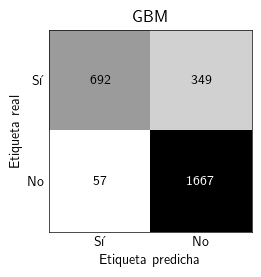

In [43]:
cu.train_and_evaluate_model(gbm, X_train_scaled, y_train, X_test_scaled, y_test, 'GBM', pos_class, neg_class)

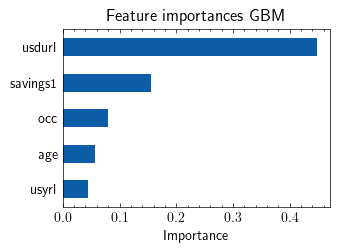

In [44]:
features=X_train_scaled.columns.to_list()
feature_imp = gbm.feature_importances_

df_feature_imp = pd.DataFrame({'importance': feature_imp}, index=features)

with plt.style.context('science'):
    ax = df_feature_imp.sort_values(by='importance', ascending=True).tail().plot.barh()
    ax.set_title('Feature importances GBM')
    ax.set_xlabel('Importance')
    ax.legend().remove()
plt.tight_layout()
ax.tick_params(axis='y', which='both',length=0)
plt.savefig(os.path.join(fu.results_path,'feature_importances_gbm.png'), dpi=300, bbox_inches='tight')
plt.show()

# Multi Layer Perceptron (MLP)

In [45]:
mlp =  MLPClassifier(max_iter=1000, learning_rate='adaptive')
#hidden_layers_range = [(20,5),(20,10),(25,5),(25,10),(30,5),(30,10),(35,5),(35,10),(40,5),(40,10),(45,5),(45,10),
#                       (50,5),(50,10),(55,5),(55,10)] #Número de neuronas en dos capas ocultas del MLP
#hidden_layers_range = [(55,5),(55,10),(60,5),(60,10),(65,5),(65,10),(70,5),(70,10),(75,5),(75,10),(80,5),(80,10),
#                       (85,5),(85,10),(90,5),(90,10),(95,5),(95,10),(100,5),(100,10)] #Número de neuronas en dos capas ocultas del MLP
hidden_layers_range = [(55,25),(55,30),(60,25),(60,30),(65,25),(65,30),(70,25),(70,30),(75,25),(75,30),(80,25),(80,30),
                       (85,25),(85,30),(90,25),(90,30),(95,25),(95,30),(100,25),(100,30)] #Número de neuronas en dos capas ocultas del MLP
alpha_range = np.logspace(-5, 0, 7) #Parámetro de regularización L2
activations = ['logistic', 'tanh', 'relu']
params = {'hidden_layer_sizes': hidden_layers_range, 'alpha': alpha_range, 'activation': activations}
best_mlp = GridSearchCV(mlp,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation,verbose=3)
start = time.time()
best_mlp.fit(X_train_scaled, y_train) 
end = time.time()
best_mcc = best_mlp.best_score_
best_alpha = best_mlp.best_params_['alpha']
best_hidden_layers = best_mlp.best_params_['hidden_layer_sizes']
best_activation = best_mlp.best_params_['activation']
fu.write_cross_val_times_to_file(
        {"Classifier": 'MLP', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best MCC: {best_mcc}, best hidden layers: {best_hidden_layers}, best alpha: {best_alpha}, best activation: {best_activation}')

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
[CV 6/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.869) matthews_corrcoef: (test=0.757) total time=   7.2s
[CV 5/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.843) matthews_corrcoef: (test=0.695) total time=   7.3s
[CV 1/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.840) matthews_corrcoef: (test=0.696) total time=   7.7s
[CV 5/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 30); balanced_accuracy: (test=0.838) matthews_corrcoef: (test=0.709) total time=   7.8s
[CV 10/10] END activation=logistic, alpha=9.999999999999999e-06, hidden_layer_sizes=(55, 25); balanced_accuracy: (test=0.855) matthews_corrcoef: (test=0.734) total time=   7.9s
[CV 2/10] END activation=logistic, alpha=9.99999999999

Curvas de aprendizaje del clasificador MLP almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador MLP almacenado en curvas_de_aprendizaje/learning_curves_times.csv


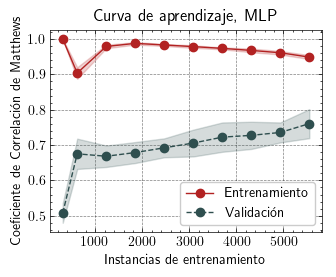

In [46]:
mlp =  MLPClassifier(hidden_layer_sizes=best_hidden_layers,alpha=best_alpha, activation=best_activation, max_iter=2500, learning_rate='adaptive')
lcu.plot_and_save_learning_curve(mlp, 'MLP', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador MLP almacenados en resultados/resultados.csv
Predicciones del clasificador MLP almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador MLP almacenado en resultados/execution_times.csv
Accuracy: 0.7566
Balanced accuracy: 0.7502
Recall: 0.7243
Specificity: 0.7761
AUC: 0.7243
MCC: 0.4925
Precision: 0.6614
F1-score: 0.6914


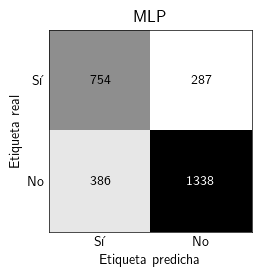

In [47]:
#mlp.out_activation_ = 'logistic'
cu.train_and_evaluate_model(mlp, X_train_scaled, y_train, X_test_scaled, y_test, 'MLP', pos_class, neg_class)

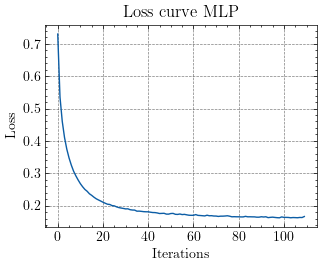

In [48]:
with plt.style.context(['science','grid']):
    fig, ax = plt.subplots()
    ax.plot(mlp.loss_curve_)
    ax.set_title('Loss curve MLP')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    plt.savefig(os.path.join(fu.results_path,'MLP_loss_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Support Vector Machines (SVMs)

## SVM con kernel lineal

## SVM con kernel RBF Gaussiana

In [49]:
rsvm = SVC(kernel='rbf')
C_range = np.logspace(-3, 0, 7)
gamma_range = np.logspace(-3, 0, 7)
params = {'C': C_range, 'gamma': gamma_range}
best_rsvm = GridSearchCV(rsvm,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit =score_validation, verbose=3)
start = time.time()
best_rsvm.fit(X_train_scaled, y_train)
end = time.time()
best_mcc = best_rsvm.best_score_
best_C = best_rsvm.best_params_['C']
best_gamma = best_rsvm.best_params_['gamma']

fu.write_cross_val_times_to_file(
        {"Classifier": 'RBF SVM', "time_s": end-start}
)
    
print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best MCC: {best_mcc}, best C: {best_C}, best gamma: {best_gamma}')

Fitting 10 folds for each of 49 candidates, totalling 490 fits
[CV 2/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   0.9s
[CV 3/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   0.9s
[CV 3/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   0.9s
[CV 5/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.0s
[CV 7/10] END C=0.001, gamma=0.001; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.0s
[CV 2/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.0s
[CV 1/10] END C=0.001, gamma=0.0031622776601683794; balanced_accuracy: (test=0.500) matthews_corrcoef: (test=0.000) total time=   1.0s
[CV 9/10] END C=0.001, gamma=0.001; bala

Curvas de aprendizaje del clasificador RBF SVM almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador RBF SVM almacenado en curvas_de_aprendizaje/learning_curves_times.csv


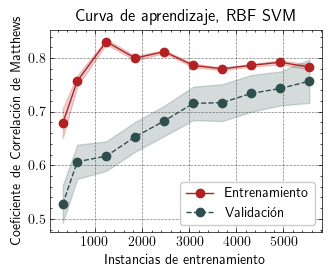

In [50]:
rsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
lcu.plot_and_save_learning_curve(rsvm, 'RBF SVM', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10, n_jobs=-1)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador RBF SVM almacenados en resultados/resultados.csv
Predicciones del clasificador RBF SVM almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador RBF SVM almacenado en resultados/execution_times.csv
Accuracy: 0.7779
Balanced accuracy: 0.7296
Recall: 0.5341
Specificity: 0.9252
AUC: 0.5341
MCC: 0.5155
Precision: 0.8117
F1-score: 0.6443


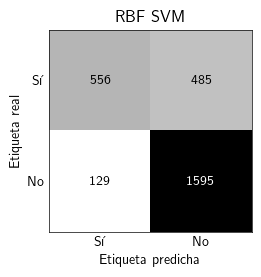

In [51]:
cu.train_and_evaluate_model(rsvm, X_train_scaled, y_train, X_test_scaled, y_test, 'RBF SVM', pos_class, neg_class)

# Regresión Logística

In [52]:
lr = LogisticRegression(max_iter=1000)
C_range = np.logspace(-3, 3, 7)
params = {'C': C_range}
best_lr = GridSearchCV(lr,params,scoring=scoring,cv=kf_cv_10,n_jobs=-1, refit=score_validation, verbose=3)
start = time.time()
best_lr.fit(X_train_scaled, y_train)
end = time.time()
best_mcc = best_lr.best_score_
best_C = best_lr.best_params_['C']

fu.write_cross_val_times_to_file(
        {"Classifier": 'Logistic Regression', "time_s": end-start}
)

print("Tiempo de ejecución: " + time.strftime("%H:%M:%S", time.gmtime(end - start)))
print(f'Best MCC: {best_mcc}, best C: {best_C}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV 3/10] END C=0.001; balanced_accuracy: (test=0.796) matthews_corrcoef: (test=0.672) total time=   0.0s
[CV 1/10] END C=0.001; balanced_accuracy: (test=0.746) matthews_corrcoef: (test=0.601) total time=   0.0s
[CV 2/10] END C=0.001; balanced_accuracy: (test=0.742) matthews_corrcoef: (test=0.618) total time=   0.0s
[CV 5/10] END C=0.001; balanced_accuracy: (test=0.756) matthews_corrcoef: (test=0.644) total time=   0.0s
[CV 3/10] END C=0.01; balanced_accuracy: (test=0.844) matthews_corrcoef: (test=0.718) total time=   0.0s
[CV 4/10] END C=0.001; balanced_accuracy: (test=0.768) matthews_corrcoef: (test=0.651) total time=   0.0s
[CV 8/10] END C=0.001; balanced_accuracy: (test=0.801) matthews_corrcoef: (test=0.693) total time=   0.0s[CV 1/10] END C=0.01; balanced_accuracy: (test=0.820) matthews_corrcoef: (test=0.696) total time=   0.0s

[CV 6/10] END C=0.001; balanced_accuracy: (test=0.785) matthews_corrcoef: (test=0.683) total 

Curvas de aprendizaje del clasificador Logistic Regression almacenadas en curvas_de_aprendizaje/curvas_de_aprendizaje.csv.
Tiempo de curvas de aprendizaje del clasificador Logistic Regression almacenado en curvas_de_aprendizaje/learning_curves_times.csv


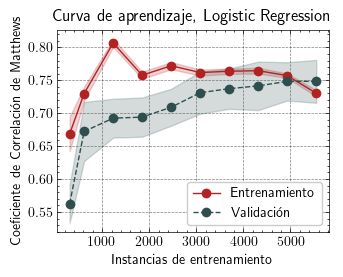

In [53]:
lr = LogisticRegression(C=best_C, max_iter=1000)
lcu.plot_and_save_learning_curve(lr, 'Logistic Regression', X_train_scaled, y_train, scoring=score_validation, cv=kf_cv_10)

Tiempo de entrenamiento: 00:00:00
Tiempo de evaluación: 00:00:00
Resultados del clasificador Logistic Regression almacenados en resultados/resultados.csv
Predicciones del clasificador Logistic Regression almacenadas en resultados/predicciones.csv.
Tiempo de ejecución del clasificador Logistic Regression almacenado en resultados/execution_times.csv
Accuracy: 0.7664
Balanced accuracy: 0.7527
Recall: 0.6974
Specificity: 0.8080
AUC: 0.6974
MCC: 0.5039
Precision: 0.6868
F1-score: 0.6921


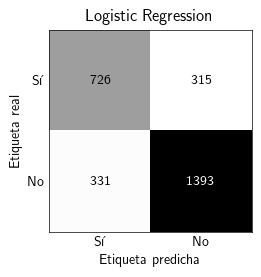

In [54]:
cu.train_and_evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'Logistic Regression', pos_class, neg_class)

# Resultados

In [55]:
#predicciones = pd.read_csv(os.path.join(fu.results_path,'predicciones.csv'))
#cmu.plot_save_all_conf_matrices(predicciones,[pos_class[0],neg_class[0]] ,[pos_class[1],neg_class[1]])

In [56]:
resultados = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'resultados.csv')))
resultados.sort_values(by='MCC', ascending=False, inplace=True)
markdown_table = resultados.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)

| Classifier          |   Accuracy |   Balanced_accuracy |   Recall |   Specificity |    AUC |    MCC |   Precision |   F1-score |
|:--------------------|-----------:|--------------------:|---------:|--------------:|-------:|-------:|------------:|-----------:|
| GBM                 |     0.8532 |              0.8158 |   0.6647 |        0.9669 | 0.8158 | 0.6887 |      0.9239 |     0.7732 |
| RBF SVM             |     0.7779 |              0.7296 |   0.5341 |        0.9252 | 0.7296 | 0.5155 |      0.8117 |     0.6443 |
| Logistic Regression |     0.7664 |              0.7527 |   0.6974 |        0.8080 | 0.7527 | 0.5039 |      0.6868 |     0.6921 |
| MLP                 |     0.7566 |              0.7502 |   0.7243 |        0.7761 | 0.7502 | 0.4925 |      0.6614 |     0.6914 |
| Decision Tree       |     0.7483 |              0.6804 |   0.4054 |        0.9553 | 0.6804 | 0.4544 |      0.8457 |     0.5481 |
| Naïve Bayes         |     0.7045 |              0.7231 |   0.7983 |        0.6479

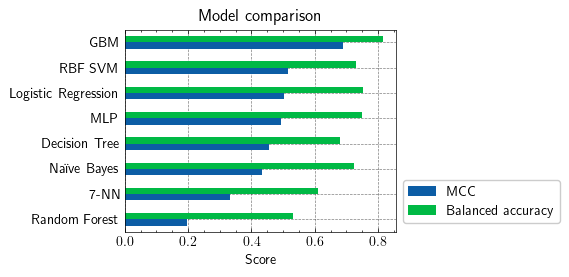

In [57]:
cu.plot_scores(resultados,['MCC','Balanced_accuracy'], ['MCC','Balanced accuracy'], 'MCC', 'Model comparison')

Learning curves de validación de todos los clasificadores

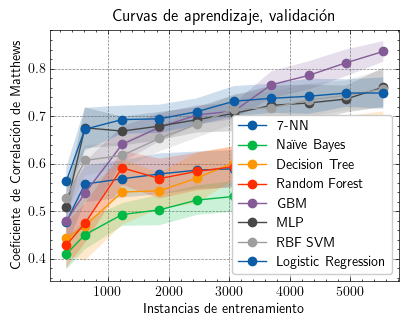

In [58]:
lcu.plot_and_save_all_learning_curves()

Tiempos de entrenamiento y prueba

In [4]:
tiempos_val = pd.read_csv(os.path.join(fu.results_path,'cross_val_times.csv'))
tiempos_e_p = pd.DataFrame(pd.read_csv(os.path.join(fu.results_path,'execution_times.csv')))
tiempos = pd.merge(tiempos_val, tiempos_e_p, on='Classifier')
tiempos.rename(columns={'time_s': 'val_s' }, inplace=True)
tiempos.sort_values(by='val_s', ascending=False, inplace=True)
markdown_table = tiempos.to_markdown(index=False, floatfmt=".4f")
# Imprimir la tabla Markdown
print(markdown_table)


| Classifier          |     val_s |   training_s |   testing_s |
|:--------------------|----------:|-------------:|------------:|
| MLP                 | 1268.9635 |       0.9511 |      0.0010 |
| Decision Tree       |  161.4611 |       0.0780 |      0.0036 |
| GBM                 |   70.5746 |      12.4143 |      0.0181 |
| RBF SVM             |   40.6113 |       0.2718 |      0.1299 |
| Random Forest       |   26.3230 |       0.2405 |      0.0258 |
| 7-NN                |    8.1230 |       0.0022 |      0.1268 |
| Logistic Regression |    0.1955 |       0.0062 |      0.0005 |
| Naïve Bayes         |    0.0000 |       0.0382 |      0.0161 |


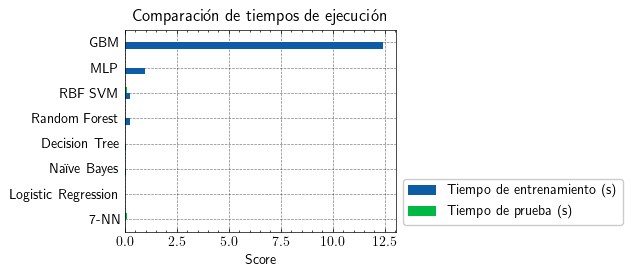

In [60]:
cu.plot_times(tiempos,['training_s','testing_s'], ['Tiempo de entrenamiento (s)','Tiempo de prueba (s)'], 'training_s', 'Comparación de tiempos de ejecución')